In [1]:
import tensorflow as tf
from glob import glob
from os.path import join
from tensorflow.keras import layers, models
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import imports.GDL_layers as GDL_layers

In [2]:
# Find a list of all the datafiles
patch_path = "/glade/scratch/lverhoef/WRF_all/track_data_hrrr_3km_nc_refl/"
patch_files = sorted(glob(join(patch_path, "*.nc")))
patch_ds = xr.open_dataset(patch_files[0])
csv_path = "/glade/scratch/lverhoef/WRF_all/track_data_hrrr_3km_csv_refl/"
csv_files = sorted(glob(join(csv_path, "track_step_*.csv")))
meta_ds = pd.read_csv(csv_files[0])

In [3]:
# Pull selected variables from patch files and join into a single DataSet
num_files = 150
train_split = int(num_files*0.7)
val_split = int(num_files*0.8)
variables = ["REFL_COM_curr", "masks"]
data_list = []
for p, patch_file in enumerate(patch_files[0:train_split]):
    if p % 10 == 0:
        print(f'Train {p}, {patch_file}')
    ds = xr.open_dataset(patch_file)
    data_list.append(ds[variables].compute())
    ds.close()
input_train = xr.concat(data_list, dim="p")["REFL_COM_curr"].expand_dims("channel", axis = -1)
train_masks = xr.concat(data_list, dim="p")["masks"]
data_list = []
for p, patch_file in enumerate(patch_files[train_split:val_split]):
    if p % 10 == 0:
        print(f'Validation {train_split + p}, {patch_file}')
    ds = xr.open_dataset(patch_file)
    data_list.append(ds[variables].compute())
    ds.close()
input_val = xr.concat(data_list, dim="p")["REFL_COM_curr"].expand_dims("channel", axis = -1)
val_masks = xr.concat(data_list, dim="p")["masks"]
data_list = []
for p, patch_file in enumerate(patch_files[val_split:num_files]):
    if p % 10 == 0:
        print(f'Test {val_split + p}, {patch_file}')
    ds = xr.open_dataset(patch_file)
    data_list.append(ds[variables].compute())
    ds.close()
input_test = xr.concat(data_list, dim="p")["REFL_COM_curr"].expand_dims("channel", axis = -1)
test_masks = xr.concat(data_list, dim="p")["masks"]

Train 0, /glade/scratch/lverhoef/WRF_all/track_data_hrrr_3km_nc_refl/NCARSTORM_20101024-0000_d01_model_patches.nc
Train 10, /glade/scratch/lverhoef/WRF_all/track_data_hrrr_3km_nc_refl/NCARSTORM_20110201-0000_d01_model_patches.nc
Train 20, /glade/scratch/lverhoef/WRF_all/track_data_hrrr_3km_nc_refl/NCARSTORM_20110326-0000_d01_model_patches.nc
Train 30, /glade/scratch/lverhoef/WRF_all/track_data_hrrr_3km_nc_refl/NCARSTORM_20110414-0000_d01_model_patches.nc
Train 40, /glade/scratch/lverhoef/WRF_all/track_data_hrrr_3km_nc_refl/NCARSTORM_20110425-0000_d01_model_patches.nc
Train 50, /glade/scratch/lverhoef/WRF_all/track_data_hrrr_3km_nc_refl/NCARSTORM_20110522-0000_d01_model_patches.nc
Train 60, /glade/scratch/lverhoef/WRF_all/track_data_hrrr_3km_nc_refl/NCARSTORM_20110605-0000_d01_model_patches.nc
Train 70, /glade/scratch/lverhoef/WRF_all/track_data_hrrr_3km_nc_refl/NCARSTORM_20110615-0000_d01_model_patches.nc
Train 80, /glade/scratch/lverhoef/WRF_all/track_data_hrrr_3km_nc_refl/NCARSTORM_2

In [4]:
# Pull variables from csv files and join into an array
csv_variables = ["major_axis_length", "minor_axis_length"]
csv_data_list = []
for p, csv_file in enumerate(csv_files[0:train_split]):
    if p % 10 == 0:
        print(f'Train {p}, {csv_file}')
    csv_ds = pd.read_csv(csv_file)
    csv_data_list.append(csv_ds[csv_variables].to_xarray().rename({'index': 'p'}))
output_train = xr.concat(csv_data_list, dim="p").to_array().transpose()
csv_data_list = []
for p, csv_file in enumerate(csv_files[train_split:val_split]):
    if p % 10 == 0:
        print(f'Validation {train_split + p}, {csv_file}')
    csv_ds = pd.read_csv(csv_file)
    csv_data_list.append(csv_ds[csv_variables].to_xarray().rename({'index': 'p'}))
output_val = xr.concat(csv_data_list, dim="p").to_array().transpose()
csv_data_list = []
for p, csv_file in enumerate(csv_files[val_split:num_files]):
    if p % 10 == 0:
        print(f'Test {val_split + p}, {csv_file}')
    csv_ds = pd.read_csv(csv_file)
    csv_data_list.append(csv_ds[csv_variables].to_xarray().rename({'index': 'p'}))
output_test = xr.concat(csv_data_list, dim="p").to_array().transpose()

Train 0, /glade/scratch/lverhoef/WRF_all/track_data_hrrr_3km_csv_refl/track_step_NCARSTORM_d01_20101024-0000.csv
Train 10, /glade/scratch/lverhoef/WRF_all/track_data_hrrr_3km_csv_refl/track_step_NCARSTORM_d01_20110201-0000.csv
Train 20, /glade/scratch/lverhoef/WRF_all/track_data_hrrr_3km_csv_refl/track_step_NCARSTORM_d01_20110326-0000.csv
Train 30, /glade/scratch/lverhoef/WRF_all/track_data_hrrr_3km_csv_refl/track_step_NCARSTORM_d01_20110414-0000.csv
Train 40, /glade/scratch/lverhoef/WRF_all/track_data_hrrr_3km_csv_refl/track_step_NCARSTORM_d01_20110425-0000.csv
Train 50, /glade/scratch/lverhoef/WRF_all/track_data_hrrr_3km_csv_refl/track_step_NCARSTORM_d01_20110522-0000.csv
Train 60, /glade/scratch/lverhoef/WRF_all/track_data_hrrr_3km_csv_refl/track_step_NCARSTORM_d01_20110605-0000.csv
Train 70, /glade/scratch/lverhoef/WRF_all/track_data_hrrr_3km_csv_refl/track_step_NCARSTORM_d01_20110615-0000.csv
Train 80, /glade/scratch/lverhoef/WRF_all/track_data_hrrr_3km_csv_refl/track_step_NCARSTO

In [5]:
print(input_train.shape)
print(input_val.shape)
print(input_test.shape)
print(output_train.shape)
print(output_val.shape)
print(output_test.shape)

(34061, 144, 144, 1)
(4300, 144, 144, 1)
(12985, 144, 144, 1)
(34061, 2)
(4300, 2)
(12985, 2)


In [6]:
# Normalize the training data
scale_stats = pd.DataFrame(index=[0], columns=["mean", "sd"])
scale_stats.loc[0, "mean"] = input_train.mean()
scale_stats.loc[0, "sd"] = input_train.std()
input_train_norm = (input_train - scale_stats.loc[0, "mean"]) / scale_stats.loc[0, "sd"]
input_val_norm = (input_val - scale_stats.loc[0, "mean"]) / scale_stats.loc[0, "sd"]
input_test_norm = (input_test - scale_stats.loc[0, "mean"]) / scale_stats.loc[0, "sd"]

In [7]:
# Normalize output data
output_scale_stats = pd.DataFrame(index=[0], columns=["mean", "sd"])
output_scale_stats.loc[0, "mean"] = output_train.mean()
output_scale_stats.loc[0, "sd"] = output_train.std()
output_train_norm = (output_train - output_scale_stats.loc[0, "mean"]) / output_scale_stats.loc[0, "sd"]
output_val_norm = (output_val - output_scale_stats.loc[0, "mean"]) / output_scale_stats.loc[0, "sd"]
output_test_norm = (output_test - output_scale_stats.loc[0, "mean"]) / output_scale_stats.loc[0, "sd"]

In [8]:
ricnn_backbone = models.Sequential()
ricnn_backbone.add(GDL_layers.RotEquivConv2D(32, (3, 3), rot_axis=False, input_shape=(144, 144, 1)))
ricnn_backbone.add(GDL_layers.RotEquivPool2D((2, 2)))
ricnn_backbone.add(GDL_layers.RotEquivConv2D(32, (3, 3)))
ricnn_backbone.add(GDL_layers.RotEquivPool2D((2, 2)))
ricnn_backbone.add(GDL_layers.RotEquivConv2D(64, (3, 3)))
ricnn_backbone.add(GDL_layers.RotEquivPool2D((2, 2)))
ricnn_backbone.add(GDL_layers.RotEquivConv2D(64, (3, 3)))
ricnn_backbone.add(GDL_layers.RotEquivPool2D((2, 2)))
ricnn_backbone.add(GDL_layers.RotEquivConv2D(128, (3, 3)))
ricnn_backbone.add(GDL_layers.RotInvPool())
ricnn_backbone.add(layers.Flatten())

2022-07-25 08:26:21.775249: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-25 08:26:28.244527: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30988 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:61:00.0, compute capability: 7.0


In [9]:
ricnn_backbone.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rot_equiv_conv2d (RotEquivC  (None, 142, 142, 4, 32)  320       
 onv2D)                                                          
                                                                 
 rot_equiv_pool2d (RotEquivP  (None, 71, 71, 4, 32)    0         
 ool2D)                                                          
                                                                 
 rot_equiv_conv2d_1 (RotEqui  (None, 69, 69, 4, 32)    9248      
 vConv2D)                                                        
                                                                 
 rot_equiv_pool2d_1 (RotEqui  (None, 34, 34, 4, 32)    0         
 vPool2D)                                                        
                                                                 
 rot_equiv_conv2d_2 (RotEqui  (None, 32, 32, 4, 64)    1

In [10]:
cnn_backbone = models.Sequential()
cnn_backbone.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(144, 144, 1)))
cnn_backbone.add(layers.MaxPooling2D((2, 2)))
cnn_backbone.add(layers.Conv2D(32, (3, 3), activation='relu'))
cnn_backbone.add(layers.MaxPooling2D((2, 2)))
cnn_backbone.add(layers.Conv2D(64, (3, 3), activation='relu'))
cnn_backbone.add(layers.MaxPooling2D((2, 2)))
cnn_backbone.add(layers.Conv2D(64, (3, 3), activation='relu'))
cnn_backbone.add(layers.MaxPooling2D((2, 2)))
cnn_backbone.add(layers.Conv2D(128, (3, 3), activation='relu'))
cnn_backbone.add(layers.Flatten())

In [11]:
cnn_backbone.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 142, 142, 32)      320       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 71, 71, 32)       0         
 2D)                                                             
                                                                 
 conv2d_1 (Conv2D)           (None, 69, 69, 32)        9248      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 34, 34, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 16, 16, 64)      

In [12]:
head = models.Sequential()
head.add(layers.Dense(32, input_shape=(3200,)))
head.add(layers.LeakyReLU(alpha=0.05))
head.add(layers.Dense(2))

In [13]:
head.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                102432    
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 2)                 66        
                                                                 
Total params: 102,498
Trainable params: 102,498
Non-trainable params: 0
_________________________________________________________________


In [14]:
cnn_model = models.Sequential()
cnn_model.add(cnn_backbone)
cnn_model.add(head)

In [15]:
cnn_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 3200)              138848    
                                                                 
 sequential_2 (Sequential)   (None, 2)                 102498    
                                                                 
Total params: 241,346
Trainable params: 241,346
Non-trainable params: 0
_________________________________________________________________


In [16]:
cnn_model.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mse']
)

In [17]:
cnn_hist = cnn_model.fit(x=input_train_norm, y=output_train_norm, epochs=10, validation_data=(input_val_norm, output_val_norm))

Epoch 1/10


2022-07-25 08:26:41.188995: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100


1065/1065 [==============================] - 53s 16ms/step - loss: 0.2842 - mse: 0.2842 - val_loss: 0.1451 - val_mse: 0.1451
Epoch 2/10
1065/1065 [==============================] - 16s 15ms/step - loss: 0.1579 - mse: 0.1579 - val_loss: 0.0908 - val_mse: 0.0908
Epoch 3/10
1065/1065 [==============================] - 16s 15ms/step - loss: 0.1143 - mse: 0.1143 - val_loss: 0.0846 - val_mse: 0.0846
Epoch 4/10
1065/1065 [==============================] - 16s 15ms/step - loss: 0.0879 - mse: 0.0879 - val_loss: 0.1131 - val_mse: 0.1131
Epoch 5/10
1065/1065 [==============================] - 16s 15ms/step - loss: 0.0702 - mse: 0.0702 - val_loss: 0.0659 - val_mse: 0.0659
Epoch 6/10
1065/1065 [==============================] - 17s 16ms/step - loss: 0.0584 - mse: 0.0584 - val_loss: 0.0614 - val_mse: 0.0614
Epoch 7/10
1065/1065 [==============================] - 17s 16ms/step - loss: 0.0476 - mse: 0.0476 - val_loss: 0.0566 - val_mse: 0.0566
Epoch 8/10
1065/1065 [==============================] - 17s

In [18]:
cnn_latent_train = cnn_backbone.predict(input_train_norm)

1065/1065 [==============================] - 9s 8ms/step


In [19]:
ricnn_backbone.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mse']
)

In [20]:
latent_ricnn_cnn_hist = ricnn_backbone.fit(x=input_train_norm, y=cnn_latent_train, epochs=10)

Epoch 1/10
1065/1065 [==============================] - 81s 71ms/step - loss: 0.0084 - mse: 0.0084
Epoch 2/10
1065/1065 [==============================] - 76s 71ms/step - loss: 0.0061 - mse: 0.0061
Epoch 3/10
1065/1065 [==============================] - 76s 71ms/step - loss: 0.0055 - mse: 0.0055
Epoch 4/10
1065/1065 [==============================] - 74s 70ms/step - loss: 0.0051 - mse: 0.0051
Epoch 5/10
1065/1065 [==============================] - 74s 70ms/step - loss: 0.0049 - mse: 0.0049
Epoch 6/10
1065/1065 [==============================] - 76s 71ms/step - loss: 0.0047 - mse: 0.0047
Epoch 7/10
1065/1065 [==============================] - 74s 70ms/step - loss: 0.0046 - mse: 0.0046
Epoch 8/10
1065/1065 [==============================] - 76s 71ms/step - loss: 0.0045 - mse: 0.0045
Epoch 9/10
1065/1065 [==============================] - 75s 71ms/step - loss: 0.0044 - mse: 0.0044
Epoch 10/10
1065/1065 [==============================] - 76s 71ms/step - loss: 0.0043 - mse: 0.0043


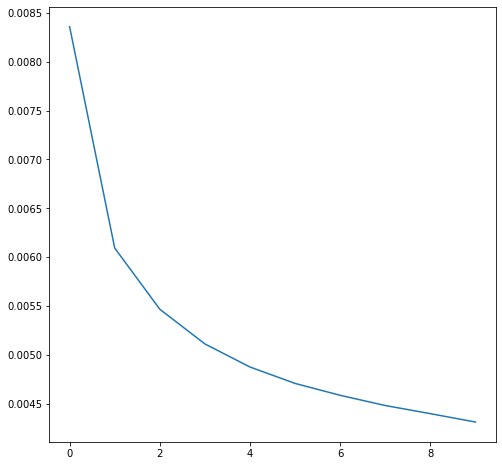

In [21]:
F, ax = plt.subplots(figsize=(8, 8))
ax.plot(latent_ricnn_cnn_hist.history['mse'])

In [22]:
lricnn_model = models.Sequential()
lricnn_model.add(ricnn_backbone)
lricnn_model.add(head)

In [23]:
lricnn_model.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mse']
)

In [24]:
lricnn_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 3200)              138848    
                                                                 
 sequential_2 (Sequential)   (None, 2)                 102498    
                                                                 
Total params: 241,346
Trainable params: 241,346
Non-trainable params: 0
_________________________________________________________________


In [25]:
ricnn_model = models.Sequential()
ricnn_model.add(GDL_layers.RotEquivConv2D(32, (3, 3), rot_axis=False, kernel_regularizer='L2', input_shape=(144, 144, 1)))
ricnn_model.add(GDL_layers.RotEquivPool2D((2, 2)))
ricnn_model.add(GDL_layers.RotEquivConv2D(32, (3, 3)))
ricnn_model.add(GDL_layers.RotEquivPool2D((2, 2)))
ricnn_model.add(GDL_layers.RotEquivConv2D(64, (3, 3)))
ricnn_model.add(GDL_layers.RotEquivPool2D((2, 2)))
ricnn_model.add(GDL_layers.RotEquivConv2D(64, (3, 3)))
ricnn_model.add(GDL_layers.RotEquivPool2D((2, 2)))
ricnn_model.add(GDL_layers.RotEquivConv2D(128, (3, 3)))
ricnn_model.add(GDL_layers.RotInvPool())
ricnn_model.add(layers.Flatten())
ricnn_model.add(layers.Dense(32, activation='relu'))
ricnn_model.add(layers.Dense(2))

In [26]:
ricnn_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rot_equiv_conv2d_5 (RotEqui  (None, 142, 142, 4, 32)  320       
 vConv2D)                                                        
                                                                 
 rot_equiv_pool2d_4 (RotEqui  (None, 71, 71, 4, 32)    0         
 vPool2D)                                                        
                                                                 
 rot_equiv_conv2d_6 (RotEqui  (None, 69, 69, 4, 32)    9248      
 vConv2D)                                                        
                                                                 
 rot_equiv_pool2d_5 (RotEqui  (None, 34, 34, 4, 32)    0         
 vPool2D)                                                        
                                                                 
 rot_equiv_conv2d_7 (RotEqui  (None, 32, 32, 4, 64)   

In [27]:
ricnn_model.compile(
    optimizer='nadam',
    loss='mse',
    metrics=['mse']
)

In [28]:
ricnn_history = ricnn_model.fit(x=input_train_norm, y=output_train_norm, epochs=10, validation_data=(input_val_norm, output_val_norm))

Epoch 1/10
1065/1065 [==============================] - 83s 73ms/step - loss: 0.3327 - mse: 0.3157 - val_loss: 0.1234 - val_mse: 0.1086
Epoch 2/10
1065/1065 [==============================] - 76s 72ms/step - loss: 0.1231 - mse: 0.1104 - val_loss: 0.0796 - val_mse: 0.0689
Epoch 3/10
1065/1065 [==============================] - 76s 71ms/step - loss: 0.0813 - mse: 0.0720 - val_loss: 0.0547 - val_mse: 0.0466
Epoch 4/10
1065/1065 [==============================] - 77s 72ms/step - loss: 0.0610 - mse: 0.0540 - val_loss: 0.0524 - val_mse: 0.0461
Epoch 5/10
1065/1065 [==============================] - 76s 71ms/step - loss: 0.0465 - mse: 0.0411 - val_loss: 0.0484 - val_mse: 0.0436
Epoch 6/10
1065/1065 [==============================] - 76s 71ms/step - loss: 0.0392 - mse: 0.0350 - val_loss: 0.0443 - val_mse: 0.0406
Epoch 7/10
1065/1065 [==============================] - 76s 72ms/step - loss: 0.0542 - mse: 0.0505 - val_loss: 0.0409 - val_mse: 0.0376
Epoch 8/10
1065/1065 [==========================

In [29]:
cnn_model.evaluate(input_test_norm, output_test_norm)
lricnn_model.evaluate(input_test_norm, output_test_norm)
ricnn_model.evaluate(input_test_norm, output_test_norm)

406/406 [==============================] - 11s 27ms/step - loss: 0.0644 - mse: 0.0622


[0.06439657509326935, 0.06221342831850052]